In [9]:
# download Breast Cancer Wisconsin (Diagnostic) Dataset 
import pandas as pd
import numpy as np
import os

# Load the dataset
df = pd.read_csv('C:\\Users\\duart\\directory\\Machine-Learning\\datasets\\breast_cancer_data.csv')
display(df.head(2))

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [16]:
# The first two collumns of the data store unique ID and diagnosis (M = malignant, B = benign)
# Use LabelEncoder to convert the diagnosis column to numerical values
from sklearn.preprocessing import LabelEncoder
# load features and labels
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)


['B' 'M']


In [17]:
# split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression()
)

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = np.sum(y_test == y_pred) / len(y_test)
print(f'Test accuracy: {test_acc:.2f}')

Test accuracy: 0.99


In [18]:
# K-fold cross-validation
import numpy as np
from sklearn.model_selection import StratifiedKFold

scores = []
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'Fold: {k+1}, Class dist.: {np.bincount(y_train[train])}, Accuracy: {score:.3f}')

Fold: 1, Class dist.: [257 152], Accuracy: 0.935
Fold: 2, Class dist.: [257 152], Accuracy: 0.913
Fold: 3, Class dist.: [257 152], Accuracy: 0.978
Fold: 4, Class dist.: [257 152], Accuracy: 0.891
Fold: 5, Class dist.: [257 152], Accuracy: 0.978
Fold: 6, Class dist.: [257 153], Accuracy: 0.956
Fold: 7, Class dist.: [258 152], Accuracy: 0.956
Fold: 8, Class dist.: [258 152], Accuracy: 0.933
Fold: 9, Class dist.: [258 152], Accuracy: 0.978
Fold: 10, Class dist.: [258 152], Accuracy: 0.911


In [19]:
# Grid Search for Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=1)
)
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['rbf'], 'svc__gamma': param_range},
    {'svc__C': param_range, 'svc__kernel': ['linear']}
]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=4)
gs = gs.fit(X_train, y_train)
print(f'Best accuracy: {gs.best_score_:.3f}')
print(f'Best parameters: {gs.best_params_}')

Best accuracy: 0.978
Best parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}


In [20]:
# Nested Cross-Validation
from sklearn.model_selection import cross_val_score
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__kernel': ['rbf'], 'svc__gamma': param_range}
]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print(f'Nested CV accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}')

Nested CV accuracy: 0.971 ± 0.015


In [21]:
# Compare with a Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print(f'Decision Tree Nested CV accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}')

Decision Tree Nested CV accuracy: 0.932 ± 0.026


In [22]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  0]
 [ 2 41]]


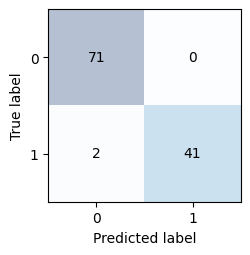

In [23]:
# Do matrix confusion plot
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()